# In depth skewed data classif.
https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now

이 노트북은 편향된 데이터에 대해 여러 테스트를 합니다. 해당 아이디어는 예측 모델의 효율성을 저해할 수 있는 어떤 압도적인 주 클래스가 있을 때 어떤 전처리가 더 잘 작동하는지를 비교합니다.

각기 다른 모델에 하이퍼파라미터 튜닝에 대한 교차 검증도 살펴 봅니다. 다음과 같은 모델을 사용합니다:
1. Logistic Regression
2. SVM
3. Decision Trees

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Loading the dataset

In [2]:
data = pd.read_csv('./input/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Checking the target classes

Text(0, 0.5, 'Frequency')

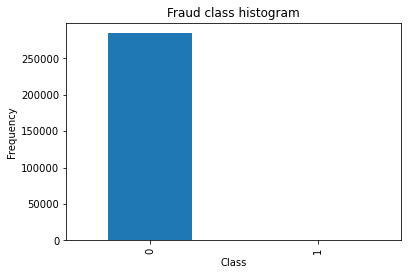

In [3]:
count_classes = pd.value_counts(data['Class'], sort=True).sort_index()
count_classes.plot(kind='bar')
plt.title('Fraud class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')

데이터가 엄청나게 불균형임을 알 수 있습니다.

이것은 일반적인 정확도 점수를 사용하여 분류 알고리즘을 평가하는 명확한 예입니다.

예를 들어, 만약 모든 데이터에 대해 주 클래스를 사용하여 값을 할당한다면, 높은 점수를 얻을 수는 있겠지만 모든 분류를 "1"로 잘못 분류할 수 있습니다.

이러한 불균형을 고려하는 분류 문제에 대해 몇 가지 접근을 해볼 수 있습니다.
- 데이터를 더 수집하는 것 -> 좋은 전략이나 이번 케이스에는 적합하지 않습니다.
- 성능 지표를 바꾸는것:
    - 혼동 매트릭스를 사용하여 Precision과 Recall을 계산
    - F1score(precision recall에 대한 가중 평균)
    - Kappa - 데이터의 불균형을 정규화한 분류 정확도
    - ROC 커브 - sensitivity/specificity ratio 계산
- 데이터셋 리샘플링
    - 데이터를 약 50대50의 비율로 맞추는 방법
    - 데이터를 적게 가지고 있을 때, 적은 수의 클래스 데이터를 복제하는 오버샘플링을 통한 방법
    - 데이터를 많이 가지고 있을 때, 많은 수의 클래스 데이터를 삭제하는 언더샘플링을 통한 방법

## Approach
1. 처음부터 피처 엔지니어링을 진행하지 않습니다. 데이터셋은 30개의 피처(28개의 익명변수 + time + amount)
2. 리샘플링을 했을 때와 하지 않았을 때를 비교합니다. 단순 로지스틱 회귀 분류기를 통해 이를 테스트 합니다.
3. 위에서 언급한 몇 가지 평가 지표를 통해 모델을 평가합니다.
4. 로지스틱 회귀 분류기의 파라미터를 조정하면서 가장 좋았던 리샘플링을 하거나/하지 않은 케이스를 반복합니다.
5. 마지막으로 다른 분류 알고리즘을 사용하여 분류를 수행합니다.

## Setting out input and target variables + resampling

### 1. amount열에 대해 정규화를 진행합니다. 

In [8]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Time', 'Amount'], axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


### 2. 리샘플링
- 처음 언급했던 것처럼, 편향된 데이터를 리샘플링하는 여러 방법이 있습니다. 언더/오버샘플링을 떠나서, 매우 인기있는 접근인 오버/언더샘플링을 조합하지만 오버샘플링을 소수 클래스를 복제하는 것이 아닌 알고리즘을 통해 새로운 소수 클래스 데이터 인스턴스를 구성하는 SMOTE(Synthetic Minority Over-Sampling Technique)가 있습니다.
- 이 노트북에서는 전통적인 언더샘플링을 사용합니다. 
- 데이터셋을 50대50 비율이 될 때 까지 언더샘플링합니다. 이는 주 클래스 샘플의 'x'만큼 선택해 소수 클래스에서 총 레코드 수를 'x'로 지정합니다.

In [9]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [17]:
# 소수 클래스의 데이터 개수
number_records_fraud = len(data[data.Class==1])
fraud_indices = np.array(data[data.Class==1].index)

# 일반 클래스의 인덱스 추출
normal_indices = data[data.Class==0].index

# 추출한 인덱스에서 랜덤하게 'x'개 선택(number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)

# 2개의 인덱스 결합
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

# 언더샘플링 데이터셋
under_sample_data = data.iloc[under_sample_indices, :]

X_undersample = under_sample_data.loc[:, under_sample_data.columns!='Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns=='Class']

# 비율
print('Ratio of normal transactions: ', len(under_sample_data[under_sample_data.Class==0])/len(under_sample_data))
print('Ratio of fraud transactions: ', len(under_sample_data[under_sample_data.Class==1])/len(under_sample_data))
print('Total number of transaction in resampled data: ', len(under_sample_data))

Ratio of normal transactions:  0.5
Ratio of fraud transactions:  0.5
Total number of transaction in resampled data:  984


## Splitting Data and Cross Validation

In [21]:
from sklearn.model_selection import train_test_split

# 전체 데이터셋
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('Number transactions train dataset: ', len(X_train))
print('Number transactions test dataset: ', len(X_test))
print('Total number of transactions: ', len(X_train)+len(X_test))

# 언더샘플링 데이터셋
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, y_undersample, test_size=0.3, random_state=0)

print("")
print('Number transactions train dataset: ', len(X_train_undersample))
print('Number transactions test dataset: ', len(X_test_undersample))
print('Total number of transactions: ', len(X_train_undersample)+len(X_test_undersample))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


## Logistic regression classifier - Undersampled data

recall score가 가장 부정한 거래를 포착하는 데 도움이 되는 평가지표이기 때문에, 이를 살펴봅니다. Precision과 recall이 혼돈 매트릭스에 어떻게 작용하는지 알고 있는 경우 recall은 매우 흥미로운 지표가 될 수 있습니다.

- Accuracy = (TP+TN)/total
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)

우리가 알고 있듯이, 데이터의 불균형때문에 많은 관측이 FN으로 관측됩니다. 따라서 Recall은 이를 포착합니다.
- 명백하게, recall을 증가시키면 precision이 감소하는 경향이 있습니다. 그러나, 이 케이스에서는 정상 거래를 사기라고 판명하는 경우가 반대인 경우보다 덜 심각한 문제입니다.
- 또한 FN과 FP를 다른 가중치를 갖는 비용함수를 적용할수도 있습니다.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

### Very ad-hoc function to print k_fold_scores

In [55]:
def printing_kfold_scores(x_train_data, y_train_data):
    fold = KFold(len(y_train_data),shuffle=False)
    
    # Different C params
    c_param_range = [0.01, 0.1, 1, 10, 100]
    
    result_table = pd.DataFrame(index=range(len(c_param_range),2), columns=['C_parameter', 'Mean recall score'])
    result_table['C_parameter'] = c_param_range
    
    # k-fold는 2개의 리스트 제공: train_indices=indices[0], test_indices=indices[1]
    j = 0
    for c_param in c_param_range:
        print('-'*30)
        print('C parameter: ', c_param)
        print('-'*30)
        print('')
        
        recall_accs = []
        for iteration, indices in enumerate(fold.split(y_train_data), start=1):
            # 특정 C 파라미터를 가진 로지스틱 회귀 모형 호출
            lr = LogisticRegression(C = c_param, penalty='l1')
            
            # 폴드된 훈련 데이터를 사용하여 모델 훈련
            # 모델을 가지고 예측
            lr.fit(x_train_data.reindex(index=indices[0],:), y_train_data.reindex(index=indices[0],:))
            
            # 훈련 데이터의 테스트 인덱스를 사용하여 값 예측
            y_pred_undersample = lr.predict(x_train_data.loc[indices[1],:].values)
            # recall score 계산 후 현재 C값과 리스트에 추가
            recall_acc = recall_score(y_train_data.loc[indices[1],:].values,
                                      y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration, ': recall score = ', recall_acc)
            
        # recall score의 평균 저장
        result_table.loc[j, 'Mean recall score'] = np.mean(recall_acc)
        j += 1
        print('')
        print('Mean recall score', np.mean(recall_accs))
        print('')
        
    best_c = result_table.loc[result_table['Mean recall score'].idxmax()]['C_parameter']
    
    # 최종적으로, 가장 최고의 C 파라미터 확인
    print('*'*30)
    print('Best model to choose from cross validation is with C parameter=', best_c)
    return best_c

SyntaxError: invalid syntax (<ipython-input-55-4774737fec73>, line 25)

In [56]:
best_c = printing_kfold_scores(X_test_undersample, y_train_undersample)

------------------------------
C parameter:  0.01
------------------------------



KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([  1,   2,   3,   4,   5,\n            ...\n            683, 684, 685, 686, 687],\n           dtype='int64', length=686). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"